# Import Packages

In [4]:
# built-in
from itertools import combinations
import os

# third-party (pip install required)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymodulon.io import load_json_model
from pymodulon.plotting import cluster_activities, plot_dima
from pymodulon.util import explained_variance, FDR
from scipy import stats
import seaborn as sns
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

# set matplotlib params
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

# Load Data

In [2]:
P1K_PATH = '../../data/precise1k/'
DEG_PATH = os.path.join(P1K_PATH, 'deg/')
ANNOTATION_PATH = '../../data/annotation/'
FIG_PATH = 'investigate_activities_figs/'

In [6]:
p1k = load_json_model(os.path.join(P1K_PATH, 'precise1k.json.gz'))
p1k_log_tpm_norm = pd.read_csv(os.path.join(P1K_PATH, 'log_tpm_norm_qc.csv'), index_col=0)
p1k.X = p1k_log_tpm_norm

# Control Comparison

## Activities

In [4]:
control_metadata = p1k.sample_table[p1k.sample_table['condition'].isin(['wt_glc', 'wt_glc2'])]
control_ids = control_metadata.index

A_ctrl = p1k.A[control_ids]
A_ctrl_mad = A_ctrl.apply(stats.median_abs_deviation, axis=1).sort_values(ascending=False)
A_ctrl_long = p1k.A[control_ids].stack().reset_index().rename(columns={'level_0': 'iM', 'level_1': 'id', 0: 'iM_activity'})
def id_to_proj(p1k_id):
    return control_metadata.loc[p1k_id, 'project']
A_ctrl_long = A_ctrl_long.assign(project=A_ctrl_long['id'].apply(id_to_proj))

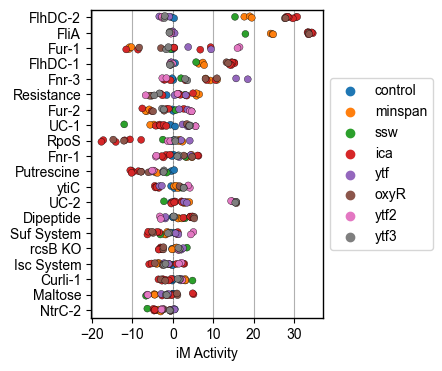

In [7]:
n_to_plot = 20

top_ims_in_order = A_ctrl_mad.index[:n_to_plot]
to_plot = A_ctrl_long[A_ctrl_long['iM'].isin(top_ims_in_order)]

_, ax = plt.subplots(figsize=(3, 4))

sns.stripplot(y='iM', x='iM_activity', data=to_plot, order=top_ims_in_order, hue='project', ax=ax, edgecolor='k', linewidth=0.25)
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
ax.set_ylabel('')
ax.set_xlabel('iM Activity', fontsize=10)
ax.set_xticks(np.arange(-20, 40, 10))
ax.axvline(0, linestyle='--', linewidth=0.5, color='gray')
ax.xaxis.grid(True)
for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1)
    
plt.savefig(os.path.join(FIG_PATH, 'ctrl_activities.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'ctrl_activities.png'), dpi=400, bbox_inches='tight')

## MADs

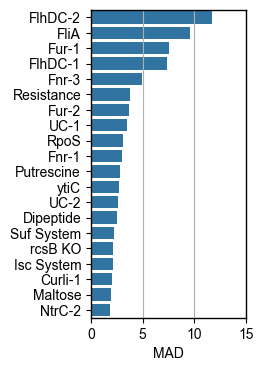

In [8]:
n_to_plot = 20
to_plot = A_ctrl_mad.iloc[:n_to_plot]
x_to_plot, y_to_plot = zip(*dict(to_plot).items())
to_plot_df = pd.DataFrame({'iM': x_to_plot, 'MAD': y_to_plot})

_, ax = plt.subplots(figsize=(2, 4))

sns.barplot(x='MAD', y='iM', orient='h', data=to_plot_df, color='tab:blue', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('MAD', fontsize=10)
ax.axvline(0, linestyle='--', linewidth=0.5, color='gray')
ax.set_xticks(np.arange(0, 20, 5))
ax.xaxis.grid(True)
for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1)
    
plt.savefig(os.path.join(FIG_PATH, 'ctrl_mads.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'ctrl_mads.png'), dpi=400, bbox_inches='tight')

# DIMA

For quicker execution use customized, streamlined version of pymodulon code

## Function: dima_fast

In [7]:
diff_dict = {}

for name, group in p1k.sample_table.groupby(["project", "condition"]):
    for i1, i2 in combinations(group.index, 2):
        diff_dict[":".join(name)] = abs(p1k.A[i1] - p1k.A[i2])

diff_df = pd.DataFrame(diff_dict)
dist_dict = {}
for k in p1k.A.index:
    dist_dict[k] = stats.lognorm(*stats.lognorm.fit(diff_df.loc[k].values)).cdf

In [8]:
def dima_fast(full_name1, full_name2, fdr=0.05, threshold=5):

    p1k_ids1 = p1k.sample_table[p1k.sample_table['full_name'] == full_name1].index
    p1k_ids2 = p1k.sample_table[p1k.sample_table['full_name'] == full_name2].index

    def pval(row):
        return 1 - dist_dict[row.name](abs(row['difference']))
    result_df = pd.DataFrame().assign(
        difference=(p1k.A[p1k_ids2].mean(axis=1) - p1k.A[p1k_ids1].mean(axis=1))
    )

    result_df = result_df.assign(
        pvalue=result_df.apply(pval, axis=1)
    )

    result_sig = FDR(result_df, fdr)
    return result_sig[(abs(result_sig.difference) > threshold)].sort_values(
        "difference", ascending=False
    )

## DIMA Histogram

In [63]:
cond_pair_to_dima_count = {}
cond_pair_to_deg_count = {}
cond_pair_to_exp_var = {}
for deg_file in tqdm(os.listdir(DEG_PATH)):
    # ensure we're dealing with a CSV
    if '.csv' in deg_file:
        full_name_1, full_name_2 = [cond.replace('__', ':') for cond in deg_file.split('.')[0].split('_vs_')]
        dima_res = dima_fast(full_name_1, full_name_2, fdr=0.1, threshold=5)
        cond_pair_to_dima_count[(full_name_1, full_name_2)] = dima_res.shape[0]
        
        # get explained variance fraction
        samp_ids = list(p1k.sample_table[p1k.sample_table['full_name'].isin([full_name_1, full_name_2])].index)
        exp_var_dima = explained_variance(p1k, samples=samp_ids, imodulons=list(dima_res.index))
        exp_var_all = explained_variance(p1k, samples=samp_ids)
        cond_pair_to_exp_var_frac[(full_name_1, full_name_2)] = (exp_var_dima, exp_var_all)
        
        # re-hash the DEG analysis so we can do DEG vs DIMA
        deg_df = pd.read_csv(os.path.join(DEG_PATH, deg_file), index_col=0)
        # only accept adjusted p-values below 0.01 and larger log-fold changes
        sig_deg_df = deg_df[(deg_df['padj'] < 0.01) & (deg_df['log2FoldChange'].abs() > 1.5)]
        cond_pair_to_deg_count[(full_name_1, full_name_2)] = sig_deg_df.shape[0]

  0%|          | 0/6104 [00:00<?, ?it/s]

/Users/cam/.venv/ica/lib/python3.10/site-packages/pymodulon/util.py:305: RuntimeWarning: invalid value encountered in double_scalars
  rec_var.append((1 - sa_err / base_err))
/Users/cam/.venv/ica/lib/python3.10/site-packages/pymodulon/util.py:305: RuntimeWarning: invalid value encountered in double_scalars
  rec_var.append((1 - sa_err / base_err))
/Users/cam/.venv/ica/lib/python3.10/site-packages/pymodulon/util.py:305: RuntimeWarning: invalid value encountered in double_scalars
  rec_var.append((1 - sa_err / base_err))
/Users/cam/.venv/ica/lib/python3.10/site-packages/pymodulon/util.py:305: RuntimeWarning: invalid value encountered in double_scalars
  rec_var.append((1 - sa_err / base_err))
/Users/cam/.venv/ica/lib/python3.10/site-packages/pymodulon/util.py:305: RuntimeWarning: invalid value encountered in double_scalars
  rec_var.append((1 - sa_err / base_err))
/Users/cam/.venv/ica/lib/python3.10/site-packages/pymodulon/util.py:305: RuntimeWarning: invalid value encountered in double_

In [72]:
deg_dima_res_df = pd.DataFrame(data={
    'cond1': [k[0] for k in cond_pair_to_dima_count.keys()],
    'cond2': [k[1] for k in cond_pair_to_dima_count.keys()],
    'n_dima': list(cond_pair_to_dima_count.values()),
    'n_deg': list(cond_pair_to_deg_count.values()),
    'exp_var_dimas': [v[0] for v in cond_pair_to_exp_var_frac.values()],
    'exp_var_all': [v[1] for v in cond_pair_to_exp_var_frac.values()]
})

In [74]:
deg_dima_res_df.to_csv(os.path.join(P1K_PATH, 'deg_dima_result.csv'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


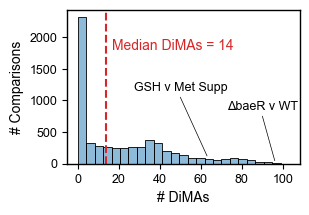

In [12]:
_, ax = plt.subplots(figsize=(3, 2))

sns.histplot(cond_pair_to_dima_count.values(), color='tab:blue', bins=25, ax=ax)

ax.legend().set_visible(False)
ax.tick_params(axis='both', labelsize=9)
ax.set_xlabel('# DiMAs', fontsize=10)
ax.set_ylabel('# Comparisons')

median_dimas = np.median(list(cond_pair_to_dima_count.values()))
ax.axvline(median_dimas, linestyle='--', color='tab:red')
ax.text(median_dimas + 2.5, 1800, f'Median DiMAs = {median_dimas:.0f}', color='tab:red', fontsize=10)

ax.plot((90, 96), (750, 50), linewidth=0.5, color='k')
ax.text(90, 800, 'ΔbaeR v WT', ha='center', va='bottom', fontsize=9, font='arial', zorder=10)

ax.plot((50, 63), (1050, 125), linewidth=0.5, color='k')
ax.text(50, 1100, 'GSH v Met Supp', ha='center', va='bottom', fontsize=9, font='arial', zorder=10)

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1)
    
plt.savefig(os.path.join(FIG_PATH, 'dimas_histogram.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'dimas_histogram.png'), dpi=400, bbox_inches='tight')

## DIMA vs DEG

19.733632642590905 DEGs per DiMA with linear fit
4483 comparisons


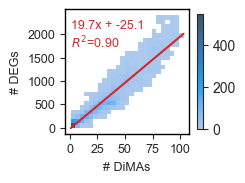

In [13]:
sns.set_style('ticks')

_, ax = plt.subplots(figsize=(2, 2))

dima_counts_to_use = {k: v for k, v in cond_pair_to_dima_count.items() if v > 0}
deg_counts_to_use = {k: v for k, v in cond_pair_to_deg_count.items() if k in dima_counts_to_use}

x_vals = list(dima_counts_to_use.values())
y_vals = list(deg_counts_to_use.values())

bestfit = np.poly1d(np.polyfit(x_vals, y_vals, 1))
r_squared = r2_score(y_vals, bestfit(x_vals))
print(f'{bestfit.coefficients[0]} DEGs per DiMA with linear fit')
print(f'{len(deg_counts_to_use)} comparisons')

sns.histplot(x=x_vals, y=y_vals,cbar=True,bins=25,
             ax=ax, color='tab:blue', cbar_kws={'shrink': 0.75})


ax.tick_params(axis='both', labelsize=9)
ax.set_yticks(np.arange(0, 2500, 500))
ax.set_xticks(np.arange(0, 110, 25))
ax.set_xlabel('# DiMAs', fontsize=9)
ax.set_ylabel('# DEGs', fontsize=9)
ax.set_aspect(1./ax.get_data_ratio())

ax.plot(np.unique(x_vals), bestfit(np.unique(x_vals)), color='tab:red')
ax.text(0.05, 0.92, f'{bestfit[1]:.1f}x + {bestfit[0]:.1f}\n$R^{2}$={r_squared:.2f}', transform=ax.transAxes, color='tab:red', fontsize=9, va='top')

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1)
    
plt.savefig(os.path.join(FIG_PATH, 'dima_v_deg.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'dima_v_deg.png'), dpi=400, bbox_inches='tight')

## DiMA Exp Var

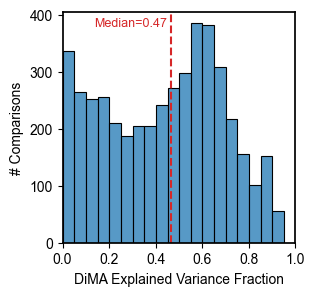

In [138]:
with_dima = deg_dima_res_df[deg_dima_res_df['n_dima'] > 0]
with_dima = with_dima.assign(
    exp_var_dimas=with_dima['exp_var_dimas'] * 100,
    exp_var_all=with_dima['exp_var_all'] * 100
)
with_dima = with_dima.assign(
    exp_var_frac=with_dima['exp_var_dimas'] / with_dima['exp_var_all']
)

med = np.median(with_dima['exp_var_frac'])

_, ax = plt.subplots(figsize=(3, 3))

sns.histplot(ax=ax, data=with_dima, x='exp_var_frac')

ax.axvline(med, linestyle='--', color='tab:red')
ax.text(0.45, 0.95, f'Median={med:.2f}', ha='right', va='center', color='tab:red', fontsize=9, transform=ax.transAxes)
ax.set_xlim(0, 1)

for s in ax.spines.values():
    s.set_linewidth(1.25)
    s.set_color('k')

ax.set_xlabel('DiMA Explained Variance Fraction')
ax.set_ylabel('# Comparisons')

plt.savefig(os.path.join(FIG_PATH, 'dima_exp_var_frac.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'dima_exp_var_frac.png'), dpi=400, bbox_inches='tight')

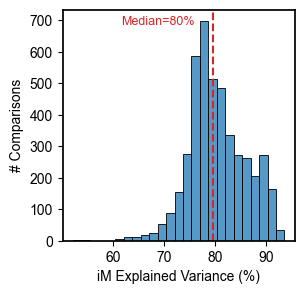

In [141]:
_, ax = plt.subplots(figsize=(3, 3))

sns.histplot(ax=ax, data=with_dima, x='exp_var_all', bins=25)

med = np.median(with_dima['exp_var_all'])
ax.axvline(med, linestyle='--', color='tab:red')
ax.text(0.57, 0.95, f"Median={med:.0f}%", ha='right', va='center', color='tab:red', fontsize=9, transform=ax.transAxes)

for s in ax.spines.values():
    s.set_linewidth(1.25)
    s.set_color('k')

ax.set_xlabel('iM Explained Variance (%)')
ax.set_ylabel('# Comparisons')

plt.savefig(os.path.join(FIG_PATH, 'im_exp_var_pct.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'im_exp_var_pct.png'), dpi=400, bbox_inches='tight')

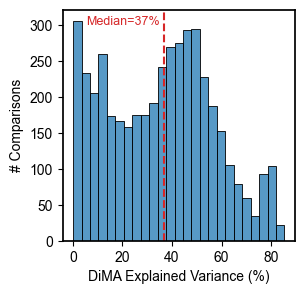

In [145]:
_, ax = plt.subplots(figsize=(3, 3))

sns.histplot(ax=ax, data=with_dima, x='exp_var_dimas', bins=25)

med = np.median(with_dima['exp_var_dimas'])
ax.axvline(med, linestyle='--', color='tab:red')
ax.text(0.42, 0.95, f"Median={med:.0f}%", ha='right', va='center', color='tab:red', fontsize=9, transform=ax.transAxes)

for s in ax.spines.values():
    s.set_linewidth(1.25)
    s.set_color('k')

ax.set_xlabel('DiMA Explained Variance (%)')
ax.set_ylabel('# Comparisons')

plt.savefig(os.path.join(FIG_PATH, 'dima_exp_var_pct.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'dima_exp_var_pct.png'), dpi=400, bbox_inches='tight')

## Example DIMA

/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/pymodulon/util.py:174: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _diff[":".join(name)] = abs(A_to_use[i1] - A_to_use[i2])
/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/pymodulon/util.py:174: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _diff[":".join(name)] = abs(A_to_use[i1] - A_to_use[i2])
/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/pymodulon/util.py:174: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

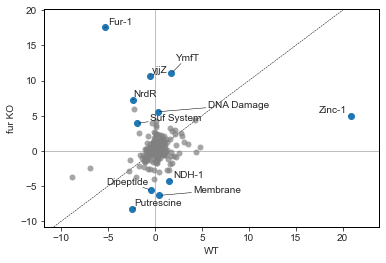

In [13]:
ax = plot_dima(p1k, 'fur:wt_fe', 'fur:delfur_fe2')

ax.set_xlabel('WT', fontsize=10)
ax.set_ylabel('fur KO', fontsize=10)
for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1)
    
plt.savefig(os.path.join(FIG_PATH, 'dima_example.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'dima_example.png'), dpi=400, bbox_inches='tight')

# Activity Clusters

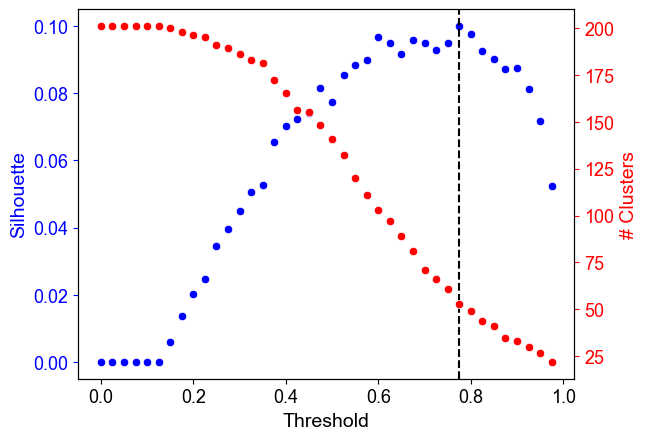

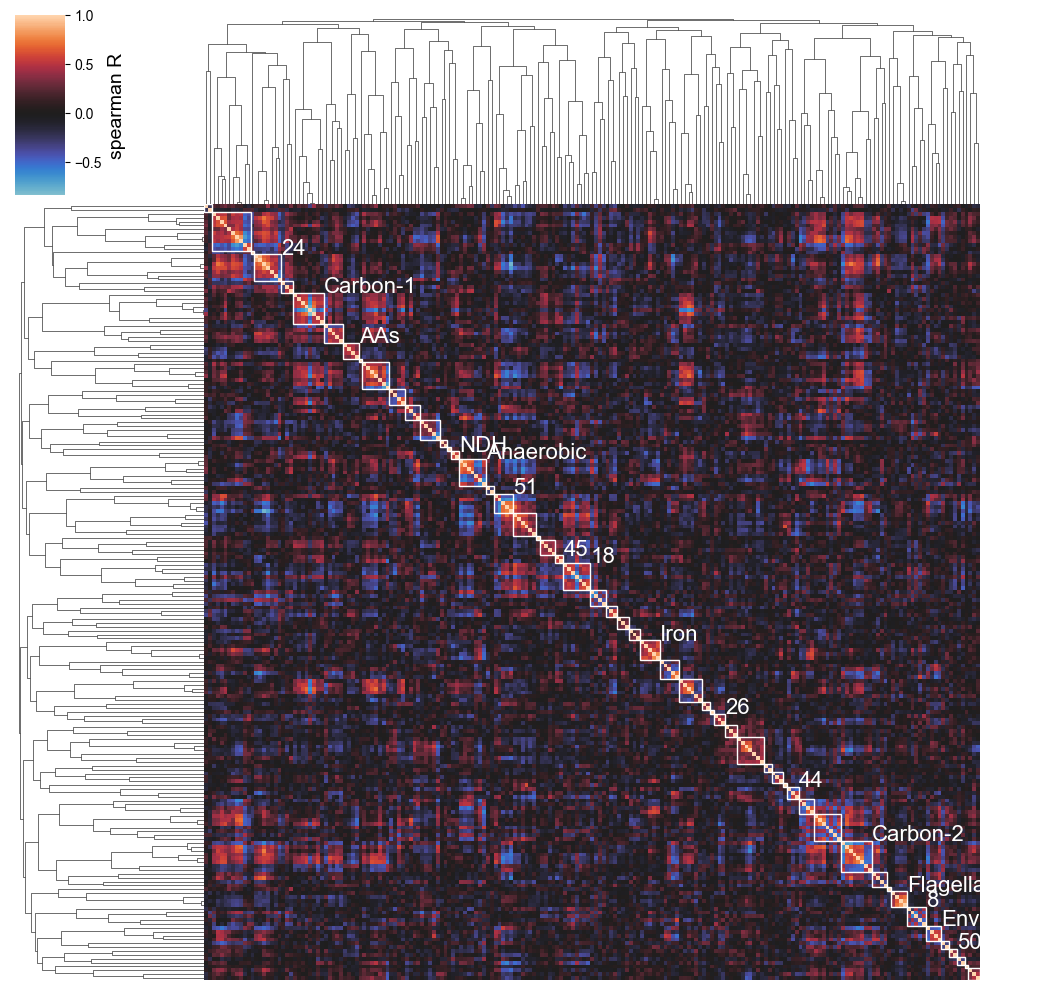

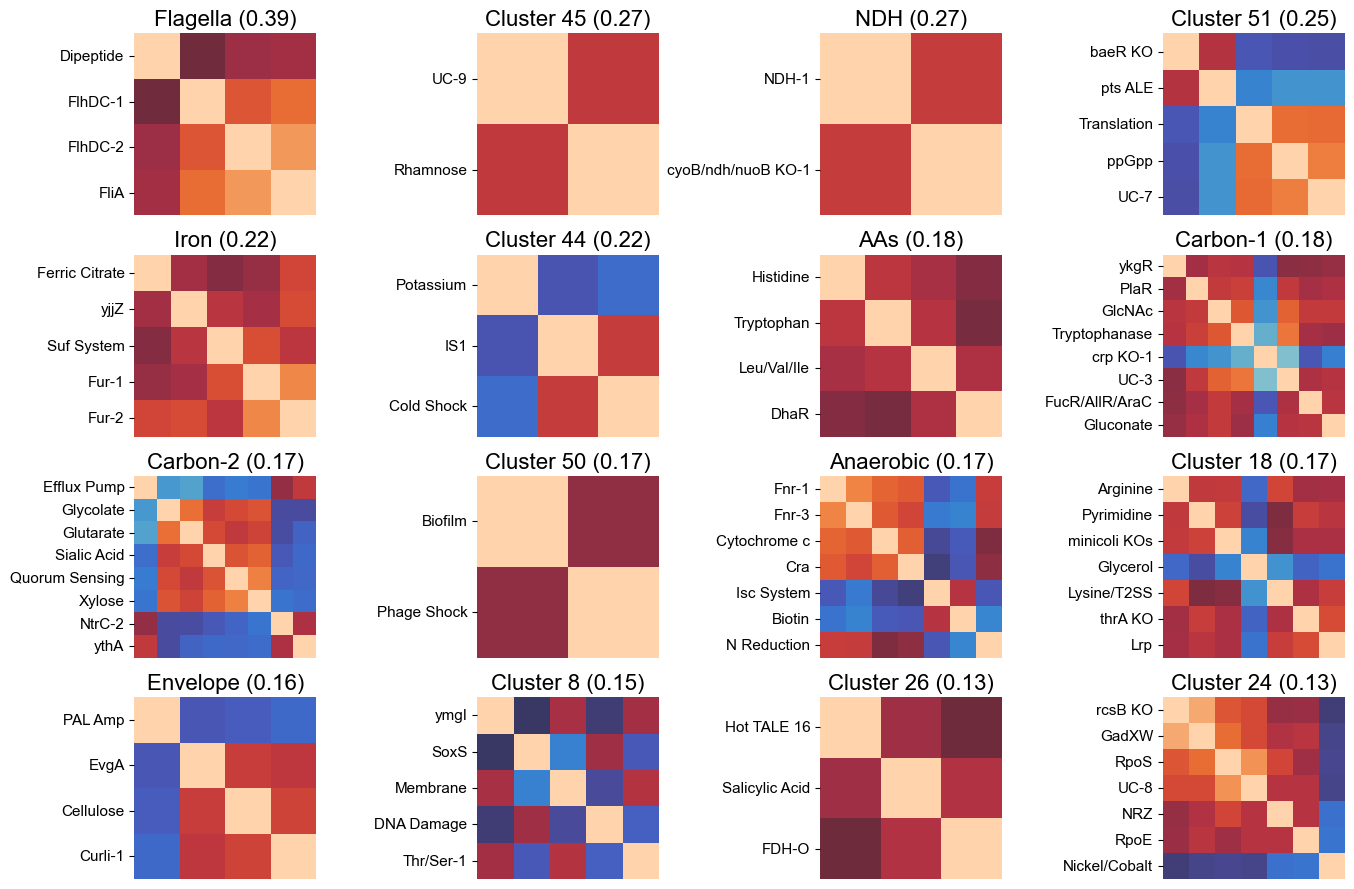

In [5]:
cluster_obj, clustermap = cluster_activities(p1k,
    show_thresholding=True, show_best_clusters=True, n_best_clusters=16, return_clustermap=True,
    cluster_names={32: 'Flagella', 49: 'NDH', 36: 'AAs', 25: 'Carbon-1', 41: 'Carbon-2', 22: 'Iron', 46: 'Envelope', 30: 'Anaerobic'}
)

# Crp Binding

## Activity Tradeoff

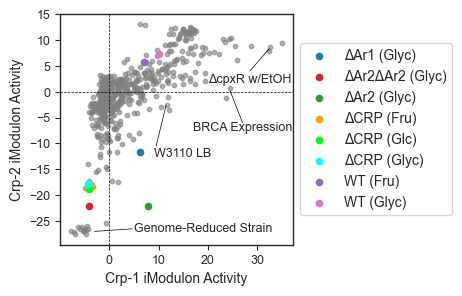

In [19]:
_, ax = plt.subplots(figsize=(3, 3))

color_dict = {
    'wt_fru': 'tab:purple',
    'wt_glyc': 'tab:pink',
    'delar1_glyc': 'tab:blue',
    'delar1ar2_glyc': 'tab:red',
    'delar2_glyc': 'tab:green',
    'delcrp_fru': 'orange',
    'delcrp_glc': 'lime',
    'delcrp_glyc': 'aqua'
}

label_dict = {
    'wt_fru': 'WT (Fru)',
    'wt_glyc': 'WT (Glyc)',
    'delar1_glyc': 'ΔAr1 (Glyc)',
    'delar1ar2_glyc': 'ΔAr2ΔAr2 (Glyc)',
    'delar2_glyc': 'ΔAr2 (Glyc)',
    'delcrp_fru': 'ΔCRP (Fru)',
    'delcrp_glc': 'ΔCRP (Glc)',
    'delcrp_glyc': 'ΔCRP (Glyc)'
}

for (proj, cond), proj_cond_df in p1k.sample_table.groupby(['project', 'condition']):
    proj_cond_idx = proj_cond_df.index
    proj_cond_act = p1k.A[proj_cond_idx].mean(axis=1)
    crp1_act, crp2_act = proj_cond_act['Crp-1'], proj_cond_act['Crp-2']
    if proj == 'crp':
        ax.scatter(crp1_act, crp2_act, s=20, c=color_dict[cond], label=label_dict[cond], zorder=10)
    else:
        ax.scatter(crp1_act, crp2_act, s=10, c='gray', alpha=0.6)
        
ax.plot((27, 24.5), (-6, 0.1), linewidth=0.5, color='k')
ax.text(27, -8, 'BRCA Expression', ha='center', va='bottom', fontsize=9, font='arial', zorder=10)

ax.plot((28.5, 32.4), (4, 8.3), linewidth=0.5, color='k')
ax.text(28.5, 1.2, 'ΔcpxR w/EtOH', ha='center', va='bottom', fontsize=9, font='arial', zorder=10)

ax.plot((4.7, -3), (-26.5, -27), linewidth=0.5, color='k')
ax.text(5, -26.5, 'Genome-Reduced Strain', ha='left', va='center', fontsize=9, font='arial', zorder=10)

ax.plot((9.5, 11.5), (-10.5, -2.65), linewidth=0.5, color='k')
ax.text(9, -12, 'W3110 LB', ha='left', va='center', fontsize=9, font='arial', zorder=10)

ax.tick_params(axis='both', labelsize=9)
ax.axvline(0, color='black', linestyle='--', linewidth=0.5)
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_xlabel('Crp-1 iModulon Activity', fontsize=10)
ax.set_ylabel('Crp-2 iModulon Activity', fontsize=10)
ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
for s in ax.spines.values():
    s.set_linewidth(1)
    
plt.savefig(os.path.join(FIG_PATH, 'crp_tradeoff.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'crp_tradeoff.png'), dpi=400, bbox_inches='tight')

In [121]:
thing.loc[['p1k_00864', 'p1k_00865']].mean(axis=0)

Crp-1    11.635608
Crp-2    -2.654014
dtype: float64

In [120]:
thing = p1k.A.loc[['Crp-1', 'Crp-2']].T
p1k.sample_table.loc[thing[(thing['Crp-1'] > 10) & (thing['Crp-2'] < -2)].index]

,sample_id,study,project,condition,rep_id,Strain Description,Strain,Culture Type,Evolved Sample,Base Media,...,contact,creator,passed_fastqc,passed_pct_reads_mapped,passed_reads_mapped_to_CDS,passed_global_correlation,full_name,passed_similar_replicates,passed_number_replicates,run_date
p1k_00054,omics__wt_thr__1,Omics,omics,wt_thr,1,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,Donghyuk Kim,Donghyuk Kim,True,True,True,True,omics:wt_thr,True,True,7/7/14
p1k_00055,omics__wt_thr__2,Omics,omics,wt_thr,2,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,Donghyuk Kim,Donghyuk Kim,True,True,True,True,omics:wt_thr,True,True,7/7/14
p1k_00151,ssw__xyl_ale1__1,Substrate-switching Evolution,ssw,xyl_ale1,1,Escherichia coli SSW_XYL.1.20.1,MG1655,Batch,Endpoint,M9,...,Troy Sandberg,Ying Hefner,True,False,True,True,ssw:xyl_ale1,True,False,4/18/17
p1k_00864,minicoli__W3110_LB__1,Minicoli,minicoli,W3110_LB,1,Escherichia coli K-12 W3110,W3110,Batch,No,M9,...,Sebastien.Rodrigue@usherbrooke.ca,Antoine Champie,True,True,True,True,minicoli:W3110_LB,True,True,5/1/19
p1k_00865,minicoli__W3110_LB__2,Minicoli,minicoli,W3110_LB,2,Escherichia coli K-12 W3110,W3110,Batch,No,M9,...,Sebastien.Rodrigue@usherbrooke.ca,Antoine Champie,True,True,True,True,minicoli:W3110_LB,True,True,5/1/19


## Binding Site Locations

This plot was generated in the Strainware-s repository using the Bitome

## Binding Simulation

NameError: name 'kinetic_data' is not defined

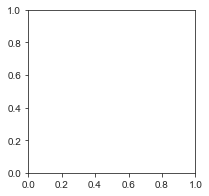

In [16]:
_, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(x='x', y='y', data=kinetic_data, s=10)
ax.tick_params(axis='both', labelsize=9)
ax.set_xlabel('Class I Fraction Bound', fontsize=10)
ax.set_ylabel('Class II Fraction Bound', fontsize=10)
for s in ax.spines.values():
    s.set_linewidth(1)
    
plt.savefig(os.path.join(FIG_PATH, 'crp_sim.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'crp_sim.png'), dpi=400, bbox_inches='tight')